# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [2]:
import tensorflow as tf
from utils import get_dataset

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [3]:
import logging
tf.get_logger().setLevel(logging.ERROR)

In [7]:
FILENAME = './data/valid/segment-10017090168044687777_6380_000_6400_000_with_camera_labels.tfrecord'
dataset = get_dataset(FILENAME)

## Write a function to display an image and the bounding boxes

Implement the `display_instances` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [8]:
def display_instances(batch):
    """
    This function takes a batch from the dataset and display the image with 
    the associated bounding boxes.
    """
    # ADD CODE HERE
    colormap = {1: [1, 0, 0], 2: [0, 1, 0], 4: [0, 0, 1]}
    
    rows = (batch+1) // 2
    fig, axis = plt.subplots(rows, 2, figsize=(50,50))
    
    for example, ax in zip(dataset.shuffle(buffer_size=1000).take(batch), axis.flat):
        
        image, boxes, labels = example['image'].numpy(), example['groundtruth_boxes'].numpy(), example['groundtruth_classes'].numpy()
        height, width, _ = image.shape

        # [ymin, xmin, ymax, xmax] 
        boxes[:,[0,2]] *= height
        boxes[:,[1,3]] *= width
        
        ax.imshow(image)
        ax.grid(False)
        ax.axis('off')
        
        for box, label in zip(boxes, labels):  
            ax.add_patch(patches.Rectangle(
                            xy=(box[1],box[0]),
                            width=box[3]-box[1],
                            height=box[2]-box[0],
                            linewidth=1,
                            edgecolor=colormap[label],
                            facecolor='none'))
    
    fig.tight_layout()
    fig.show()        

## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

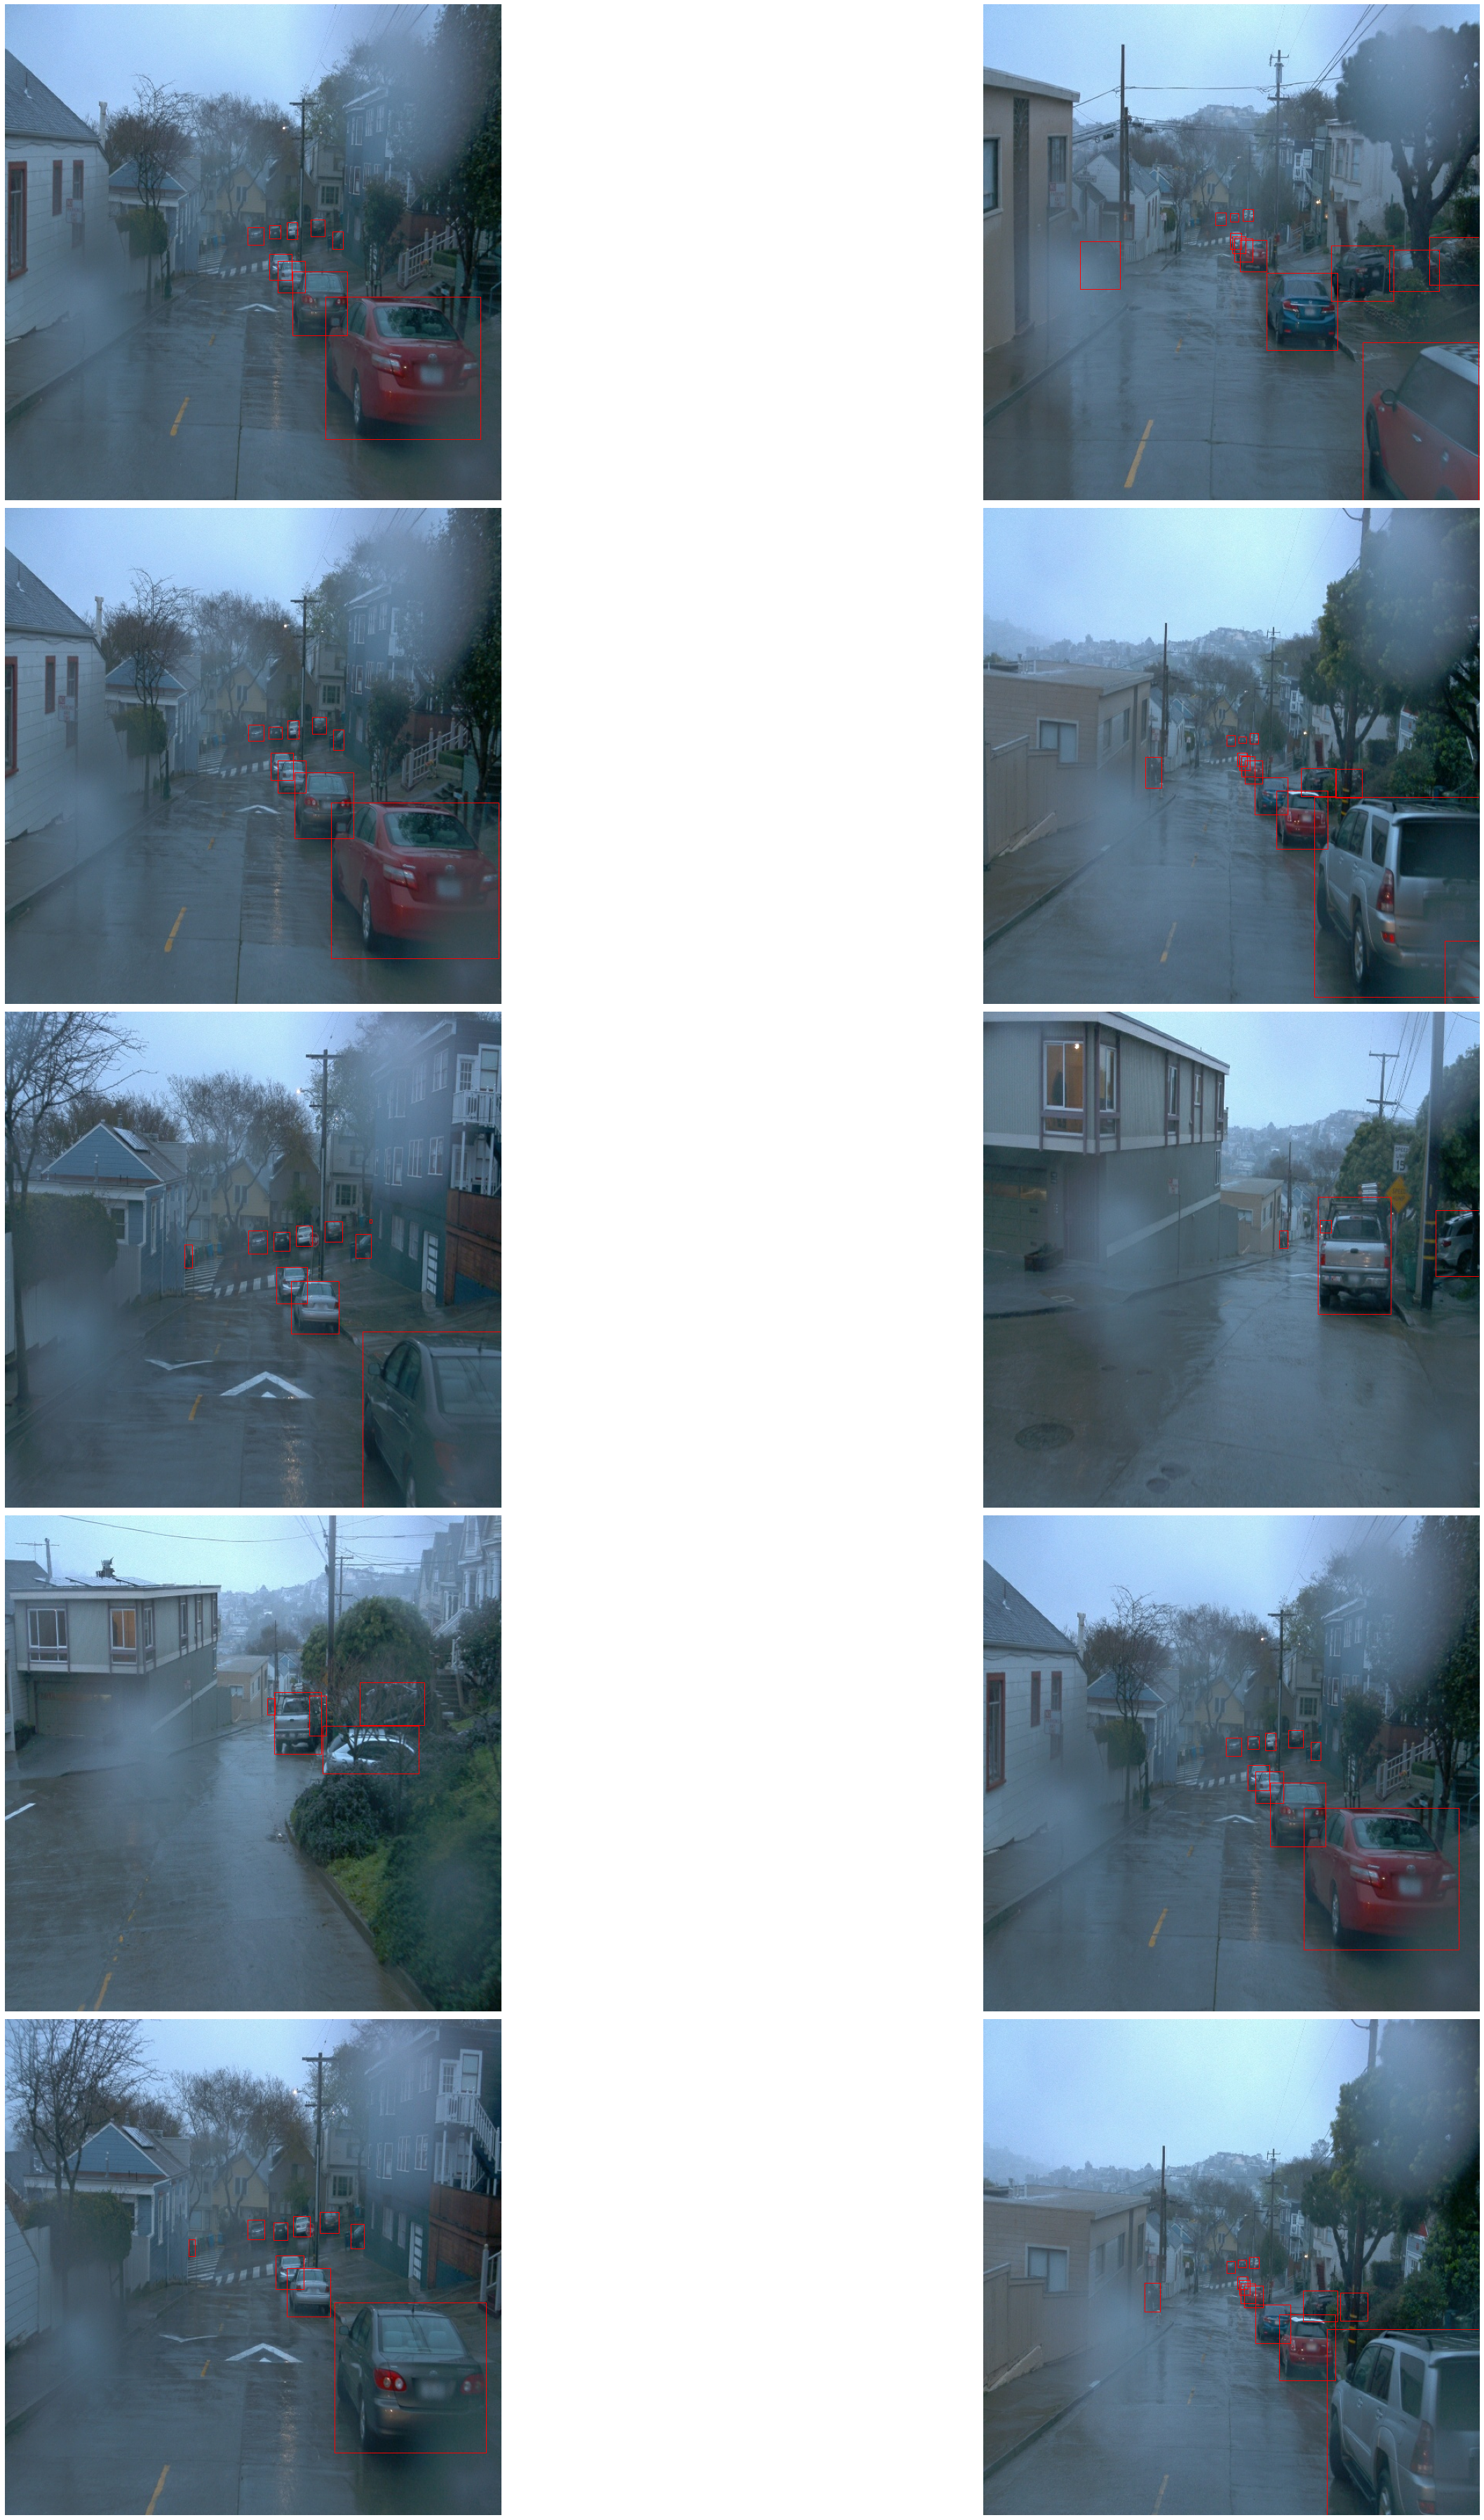

In [10]:
## STUDENT SOLUTION HERE
display_instances(10)

## Additional EDA

In this last part, you are free to perform any additional analysis of the dataset. What else would like to know about the data?
For example, think about data distribution. So far, you have only looked at a single file...

### Object Type Distribution

In [11]:
from object_detection.protos import input_reader_pb2
from object_detection.builders.dataset_builder import build as build_dataset

In [12]:
def get_dataset_ext(tfrecord_path, epochs = 1, shuffle = False, label_map='label_map.pbtxt'):
    input_config = input_reader_pb2.InputReader()
    input_config.label_map_path = label_map
    input_config.shuffle = shuffle
    input_config.num_epochs = epochs
    input_config.tf_record_input_reader.input_path[:] = [tfrecord_path]
    
    dataset = build_dataset(input_config)
    return dataset

In [17]:
import glob

def display_distribution():
    n_vehicle, n_pedestrian, n_cyclist = 0, 0, 0
    for i, dataset_file_path in enumerate(glob.glob('./data/**/*.tfrecord'),1):
        #print('file-{} : {}'.format(i, dataset_file_path))
        dataset = get_dataset_ext(dataset_file_path)
        for example in dataset:
            labels = example['groundtruth_classes'].numpy()
            for label in labels:  
                if label == 1:
                    n_vehicle += 1
                elif label == 2:
                    n_pedestrian += 1
                elif label == 4:
                    n_cyclist += 1
                else:
                    raise Exception('an incorrect label type : {}'.format(label))
    
    print('the count of vehicles = {}'.format(n_vehicle))
    print('the count of pedestrians = {}'.format(n_pedestrian))
    print('the count of cyclists = {}'.format(n_cyclist))    
    
    plt.figure(figsize=(5,5))
    plt.bar(['vehicle','pedestrian','cyclist'], [n_vehicle, n_pedestrian, n_cyclist], color = ['orange','blue','green'])
    plt.xlabel('Object Type')
    plt.ylabel('count')
    plt.show()

the count of vehicles = 352694
the count of pedestrians = 103664
the count of cyclists = 2639


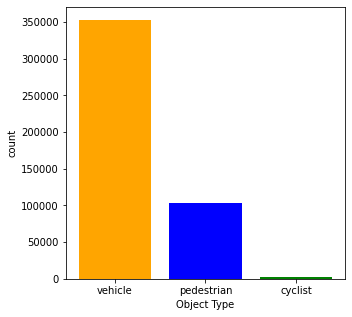

In [18]:
display_distribution()

**Conclusion**
- Our training dataset has the lack of the number of pedestrian samples and cyclist samples comparing to that of vehicle samples.  
- Especially, the count of cyclist samples is abolutely small.
- Therefore, it would be challenging for our model to dectect cyclists.